**Project Overview**

The goal of this project is to collect motion data, extract meaningful features, and use a Hidden Markov Model (HMM) to infer human activity states such as standing, walking, jumping, and still.

Sensors Recorded:
- **Accelerometer:** x, y, z axes
- **Gyroscope:** x, y, z axes

Activities Performed:
| Activity | Duration | Notes |
|-----------|-----------|--------|
| Standing | 5–10 s | Keep the phone steady at waist level |
| Walking | 5–10 s | Maintain a consistent pace |
| Jumping | 5–10 s | Perform 3–5 continuous jumps |
| Still | 5–10 s | Place the phone on a flat surface |

Each recording was taken at a sampling rate of **70 Hz**, and the collected data was saved as `.csv` files with timestamps.


**Feature Extraction Summary**

From the raw accelerometer and gyroscope readings, features were extracted in both **time** and **frequency** domains to capture movement patterns.

Examples of extracted features:
- **Time-domain features:** mean, variance, standard deviation, signal magnitude area (SMA), correlations between axes.
- **Frequency-domain features:** dominant frequency, spectral energy, FFT components.

The extracted features were saved in a file called `features.csv`, which contains all four activities combined with their corresponding labels.


Load Extracted Data

In [9]:
import pandas as pd

# Load preprocessed features
df = pd.read_csv("features.csv")

# Standardize column name to 'label'
df.rename(columns={'activity': 'label', 'Activity': 'label', 'Label': 'label'}, inplace=True)

# Display basic information
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (948, 94)


,accel_x_mean,accel_x_std,accel_x_var,accel_x_mad,accel_y_mean,accel_y_std,accel_y_var,accel_y_mad,accel_z_mean,accel_z_std,...,acc_res_dom_freq,acc_res_spec_energy,acc_res_fft_top1_mag,acc_res_fft_top1_freq,acc_res_fft_top2_mag,acc_res_fft_top2_freq,acc_res_fft_top3_mag,acc_res_fft_top3_freq,label,start_time
0,-0.325147,1.005483,1.010997,0.715388,-0.125287,1.950710,3.805271,1.288558,-0.052421,7.376959,...,0.781250,50.754583,248.492811,0.781250,224.096697,0.390625,147.161871,3.906250,jumping,1.761134e+09
1,-0.333427,1.212630,1.470472,0.896227,-0.036922,2.340061,5.475887,1.697479,0.170994,8.711320,...,3.906250,65.812950,183.212361,3.906250,164.318067,1.953125,137.923398,0.781250,jumping,1.761134e+09
2,-0.150583,1.298404,1.685853,0.915027,-0.092910,1.918203,3.679501,1.403808,-0.045061,8.365517,...,3.906250,64.546681,193.348538,3.906250,176.854559,1.953125,164.362721,5.859375,jumping,1.761134e+09
3,-0.137955,1.175404,1.381574,0.768837,-0.245090,1.596382,2.548437,1.141766,0.054054,7.954364,...,0.781250,58.464855,275.642796,0.781250,175.347922,3.906250,158.849126,0.390625,jumping,1.761134e+09
4,-0.134741,0.959452,0.920549,0.607052,-0.155564,1.428992,2.042019,0.890355,0.201396,6.758013,...,0.390625,41.634446,379.684283,0.390625,128.718180,3.906250,118.783268,3.515625,jumping,1.761134e+09


Data Inspection

In [10]:
# Check for missing values and class distribution
print("Missing values:\n", df.isna().sum())
print("\nClass distribution:\n", df['label'].value_counts())

Missing values:
 accel_x_mean             0
accel_x_std              0
accel_x_var              0
accel_x_mad              0
accel_y_mean             0
                        ..
acc_res_fft_top2_freq    0
acc_res_fft_top3_mag     0
acc_res_fft_top3_freq    0
label                    0
start_time               0
Length: 94, dtype: int64

Class distribution:
 label
walking     266
still       247
jumping     227
standing    208
Name: count, dtype: int64


**Defining Model Components**

In a Hidden Markov Model (HMM), we define the following key elements:

| Element | Description |
|----------|--------------|
| **Hidden States (Z)** | The underlying activities (e.g., standing, walking, jumping, still). |
| **Observations (X)** | Feature vectors derived from accelerometer and gyroscope signals. |
| **Transition Probabilities (A)** | Probability of transitioning from one activity to another. |
| **Emission Probabilities (B)** | Probability of observing a specific feature pattern given an activity. |
| **Initial State Probabilities (π)** | Likelihood of starting in a specific activity. |

We will now define these components based on our dataset.

Preparing data for HMM

In [14]:
import numpy as np

# Separate features (X) and labels (y)
X = df.drop(columns=['label']).values
y = df['label'].values

# Define hidden states
states = sorted(df['label'].unique())
n_states = len(states)

# Map labels to numeric states
state_map = {name: i for i, name in enumerate(states)}
y_encoded = np.array([state_map[label] for label in y])

print("Hidden States:", states)
print("Feature Matrix Shape:", X.shape)

Hidden States: ['jumping', 'standing', 'still', 'walking']
Feature Matrix Shape: (948, 93)


In [16]:
from hmmlearn import hmm

# Observations (feature vectors)
feature_columns = [col for col in df.columns if col not in ["label"]]
X = df[feature_columns].values

# You can optionally reshape if needed
lengths = [len(X)]

# Define HMM model structure (GaussianHMM for continuous features)
model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100, random_state=42)

# Fit the model to your data
model.fit(X, lengths)

# Extract model components
A = model.transmat_          # Transition probabilities
B_means = model.means_       # Emission means
B_covars = model.covars_     # Emission covariances
pi = model.startprob_        # Initial state probabilities

print("\nTransition Probabilities (A):\n", A)
print("\nEmission Means (B):\n", B_means)
print("\nInitial State Probabilities (π):\n", pi)



Transition Probabilities (A):
 [[0.92936699 0.01917551 0.00319592 0.04826158]
 [0.02659574 0.94148936 0.03191489 0.        ]
 [0.00833333 0.01666667 0.97083333 0.00416667]
 [0.07327002 0.00485199 0.         0.92187799]]

Emission Means (B):
 [[-9.51299654e-02  9.46929636e-01  1.05210371e+00  7.53142406e-01
  -2.59031913e-01  9.19210402e-01  9.96963438e-01  7.51855742e-01
   1.86519599e-01  1.99149167e+00  4.94176067e+00  1.61097023e+00
  -3.74540813e-02 -7.06094550e-02  8.78016009e-02  3.49441387e+00
   8.87026156e-01  2.46652072e+00  5.40720454e+01  8.87026156e-01
   3.64260503e+01  1.33365043e+00  2.68168016e+01  1.97552495e+00
   8.70471490e-01  2.32850685e+00  5.63898738e+01  8.70471490e-01
   3.54072622e+01  1.13591204e+00  2.44337553e+01  1.86439302e+00
   1.36724999e+00  1.23620650e+01  1.20479578e+02  1.36724999e+00
   7.68416059e+01  1.73049877e+00  5.57014400e+01  2.02691031e+00
   2.31032812e-02  4.78511832e-01  2.73307120e-01  3.75283257e-01
   4.22118688e-02  4.64978416e-

Visualizing Transitions

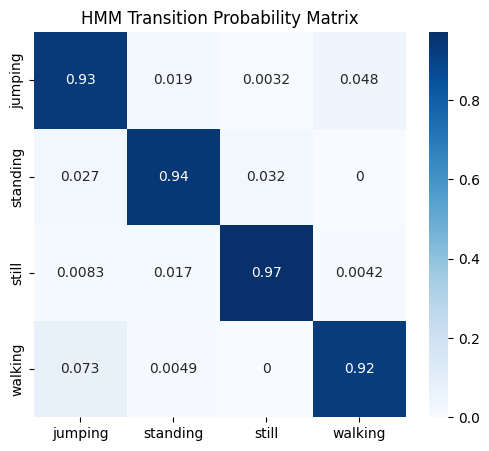

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(A, annot=True, cmap="Blues", xticklabels=states, yticklabels=states)
plt.title("HMM Transition Probability Matrix")
plt.show()

This matrix was created by computing simple transition frequencies between our activity labels in features.csv.

That means:
- We have real transitions estimated from your labeled sequences.
- But the HMM parameters (like emission probabilities and the actual fitted A matrix) are not yet optimized — they’ll be updated after model training.